In [126]:
# %% [markdown]
# # 🔬 Predicción de mineralogía sin transformación CLR
# 
# Este notebook evalúa el rendimiento de un modelo Random Forest multisalida para predecir porcentajes de arcillas, cuarzo y carbonatos directamente (sin usar transformaciones composicionales como CLR).
# 
# **Objetivo:** Evaluar si este enfoque mejora la capacidad de generalización, especialmente en valores extremos.

# %% 📦 Librerías
import warnings
warnings.filterwarnings("ignore")

# Manipulación de datos
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
import lasio
import glob

las_dir = "data/Curvas VSH"
las_paths = glob.glob(f"{las_dir}/*.las")

las_dfs = {}
for path in las_paths:
    las = lasio.read(path)
    df = las.df()
    las_dfs[path] = df

# Mostrar nombres y tamaños
for k, df in las_dfs.items():
    print(f"{k}: {df.shape}")

data/Curvas VSH\CERRO GORDO-3_PETROFISICA_2025_QC.las: (18481, 1)
data/Curvas VSH\COYOTE-1_Petrofisica_2024_VF.las: (22966, 1)
data/Curvas VSH\GALA-1K_Petrofisica_2024_VF.las: (27055, 1)
data/Curvas VSH\IWANA-1_LQC_2.las: (23274, 1)
data/Curvas VSH\LA LUNA-1_Petrofisica_2024_VF.las: (37036, 1)
data/Curvas VSH\ORIPAYA-2_PETROFISICA_2025_QC.las: (25745, 1)
data/Curvas VSH\PETROLEA 224_PETROFISICA_2025_QC.las: (3801, 1)
data/Curvas VSH\PETROLEA-231_PETROFISICA_2025_QC.las: (3065, 1)
data/Curvas VSH\PROMETEO-1_Petrofisica_2024_VF.las: (26948, 1)
data/Curvas VSH\SELVA-1_PETROFISICA_2025_QC.las: (20051, 1)


In [129]:
for nombre, df in las_dfs.items():
    print(f"--- {nombre} ---")
    print(df.describe())
    print()

--- data/Curvas VSH\CERRO GORDO-3_PETROFISICA_2025_QC.las ---
         VSH_FINAL
count  2402.000000
mean      0.578802
std       0.306067
min       0.002392
25%       0.264318
50%       0.695041
75%       0.834026
max       0.999962

--- data/Curvas VSH\COYOTE-1_Petrofisica_2024_VF.las ---
       VSH_2024_FINAL
count     8551.000000
mean         0.455331
std          0.279355
min          0.000000
25%          0.214184
50%          0.438198
75%          0.697384
max          1.000000

--- data/Curvas VSH\GALA-1K_Petrofisica_2024_VF.las ---
       VSH_2024_FINAL
count    10478.000000
mean         0.361149
std          0.234223
min          0.003439
25%          0.165119
50%          0.318916
75%          0.527321
max          0.955853

--- data/Curvas VSH\IWANA-1_LQC_2.las ---
         VSH_FINAL
count  8343.000000
mean      0.483015
std       0.242636
min       0.000000
25%       0.279507
50%       0.476912
75%       0.679767
max       0.999990

--- data/Curvas VSH\LA LUNA-1_Petrofisica

In [131]:
for k, df in las_dfs.items():
    df_reset = df.reset_index()
    df_reset.rename(columns={df_reset.columns[0]: "Depth"}, inplace=True)
    las_dfs[k] = df_reset

# Verificar
for k, df in las_dfs.items():
    print(df.columns)

Index(['Depth', 'VSH_FINAL'], dtype='object')
Index(['Depth', 'VSH_2024_FINAL'], dtype='object')
Index(['Depth', 'VSH_2024_FINAL'], dtype='object')
Index(['Depth', 'VSH_FINAL'], dtype='object')
Index(['Depth', 'VSH_2024_FINAL'], dtype='object')
Index(['Depth', 'VSH_FINAL'], dtype='object')
Index(['Depth', 'VSH_FINAL'], dtype='object')
Index(['Depth', 'VSH_FINAL'], dtype='object')
Index(['Depth', 'VSH_2024_FINAL'], dtype='object')
Index(['Depth', 'VSH_FINAL'], dtype='object')


In [ ]:
for path, df in las_dfs.items():
    cols = df.columns
    if "VSH_2024_FINAL" in cols:
        df = df.rename(columns={"VSH_2024_FINAL": "Vshale"})
    if "VSH_FINAL" in cols:
        df = df.rename(columns={"VSH_FINAL": "Vshale"})
    las_dfs[path] = df

# Verificar
for k, df in las_dfs.items():
    print(df.columns)

data/Curvas VSH\CERRO GORDO-3_PETROFISICA_2025_QC.las: ['Depth', 'Vshale']
data/Curvas VSH\COYOTE-1_Petrofisica_2024_VF.las: ['Depth', 'Vshale']
data/Curvas VSH\GALA-1K_Petrofisica_2024_VF.las: ['Depth', 'Vshale']
data/Curvas VSH\IWANA-1_LQC_2.las: ['Depth', 'Vshale']
data/Curvas VSH\LA LUNA-1_Petrofisica_2024_VF.las: ['Depth', 'Vshale']
data/Curvas VSH\ORIPAYA-2_PETROFISICA_2025_QC.las: ['Depth', 'Vshale']
data/Curvas VSH\PETROLEA 224_PETROFISICA_2025_QC.las: ['Depth', 'Vshale']
data/Curvas VSH\PETROLEA-231_PETROFISICA_2025_QC.las: ['Depth', 'Vshale']
data/Curvas VSH\PROMETEO-1_Petrofisica_2024_VF.las: ['Depth', 'Vshale']
data/Curvas VSH\SELVA-1_PETROFISICA_2025_QC.las: ['Depth', 'Vshale']


In [135]:
for path, df in las_dfs.items():
    well_name = path.split("\\")[-1].replace(".las", "")
    df["Well"] = well_name
    las_dfs[path] = df

In [136]:
# Verificar
for k, df in las_dfs.items():
    print(df.columns)

Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Depth', 'Vshale', 'Well'], dtype='object')


In [137]:
combo = pd.concat(list(las_dfs.values()), ignore_index=True)

In [139]:
combo.dropna(inplace=True)  # Eliminar filas con NaN

In [140]:
combo

,Depth,Vshale,Well
7924,3961.9295,0.225008,CERRO GORDO-3_PETROFISICA_2025_QC
7925,3962.4295,0.199607,CERRO GORDO-3_PETROFISICA_2025_QC
7926,3962.9295,0.201018,CERRO GORDO-3_PETROFISICA_2025_QC
7927,3963.4295,0.225497,CERRO GORDO-3_PETROFISICA_2025_QC
7928,3963.9295,0.257181,CERRO GORDO-3_PETROFISICA_2025_QC
...,...,...,...
205714,8671.5000,0.500652,SELVA-1_PETROFISICA_2025_QC
205715,8672.0000,0.504671,SELVA-1_PETROFISICA_2025_QC
205716,8672.5000,0.470607,SELVA-1_PETROFISICA_2025_QC
205717,8673.0000,0.395457,SELVA-1_PETROFISICA_2025_QC


In [143]:
# Diccionario de equivalencias
well_map = {
    "CERRO GORDO-3_PETROFISICA_2025_QC": "Cerro Gordo",
    "COYOTE-1_Petrofisica_2024_VF": "Coyote-1",
    "GALA-1K_Petrofisica_2024_VF": "Pico Plata 1",   # ojo: revisa si este es "Gala-1K" o "Pico Plata 1"
    "IWANA-1_LQC_2": "Iwana-1",
    "LA LUNA-1_Petrofisica_2024_VF": "Luna-1",
    "ORIPAYA-2_PETROFISICA_2025_QC": "Oripaya-2",
    "PETROLEA 224_PETROFISICA_2025_QC": "Petrolea-224",
    "PETROLEA-231_PETROFISICA_2025_QC": "Petrolea-231",
    "PROMETEO-1_Petrofisica_2024_VF": "Prometeo-1",
    "SELVA-1_PETROFISICA_2025_QC": "Selva-1"
}

# Aplicar el mapeo
combo["Well"] = combo["Well"].map(well_map)

# Verificar
print(combo["Well"].unique())

['Cerro Gordo' 'Coyote-1' 'Pico Plata 1' 'Iwana-1' 'Luna-1' 'Oripaya-2'
 'Petrolea-224' 'Petrolea-231' 'Prometeo-1' 'Selva-1']


In [144]:
# statistics for combo
combo.describe()

,Depth,Vshale
count,75021.000000,75021.000000
mean,9413.425560,0.430923
std,3323.051171,0.711106
min,69.685000,0.000000
25%,8056.500000,0.187144
50%,9810.000000,0.414691
75%,11468.000000,0.628269
max,16119.000000,68.836880


In [155]:
mask_luna = (combo["Well"] == "Luna-1") & (combo["Vshale"] > 1)
combo.loc[mask_luna, "Vshale"] = combo.loc[mask_luna, "Vshale"] / 100

In [156]:
# statistics for combo
combo.describe()

,Depth,Vshale
count,75021.000000,75021.000000
mean,9413.425560,0.420918
std,3323.051171,0.259654
min,69.685000,0.000000
25%,8056.500000,0.186985
50%,9810.000000,0.414445
75%,11468.000000,0.627926
max,16119.000000,1.000000


In [162]:
vmm_df = pd.read_csv('data/combined_df_VMM.csv', skiprows=1)

In [163]:
catatumbo_df = pd.read_csv('data/combined_df_catatumbo.csv', skiprows=1)

In [164]:
# combine both dataframes
combined_df = pd.concat([vmm_df, catatumbo_df], ignore_index=True)

In [165]:
combined_df.head()

,Well,Depth,Clay,Quartz,Carbonates,TOC,Formation,Sonic,GammaRay,NeutronPorosity,Resistivity,Density,Photoelectric,AvgPorosity,RHOMAA,UMA,GR_Dens,PEF_Dens,Porosity
0,Coyote-1,7200.0,48.675996,49.526372,1.797632,2.672507,El Salto,80.00674,61.79465,0.24560,21.25296,2.59795,5.7005,0.200711,2.999215,18.402937,23.785927,2.194230,NaN
1,Coyote-1,7214.5,28.392838,57.018752,14.588410,3.218767,El Salto,74.89855,109.48310,0.25430,36.39704,2.46675,8.7508,0.226427,2.896073,27.757992,44.383541,3.547502,NaN
2,Coyote-1,7215.0,82.689167,16.548721,0.762112,3.976217,El Salto,75.93570,106.21910,0.25615,42.38375,2.47125,8.9295,0.227161,2.903694,28.406222,42.981932,3.613354,NaN
3,Coyote-1,7232.0,82.195781,17.577069,0.227150,8.061749,El Salto,76.33705,115.05360,0.28790,184.61350,2.37395,7.7611,0.265648,2.870970,24.908553,48.465048,3.269277,NaN
4,Coyote-1,7240.0,39.656924,43.132829,17.210247,4.956246,El Salto,77.64470,117.64320,0.18490,51.75293,2.35775,7.9863,0.191456,2.679253,23.170002,49.896384,3.387255,NaN


In [166]:
combined_df['Well'].unique()

array(['Coyote-1', 'Luna-1', 'Prometeo-1', 'Iwana-1', 'Pico Plata 1',
       'Selva-1', 'Cerro Gordo', 'Oripaya-2', 'Petrolea-231',
       'Petrolea-224'], dtype=object)

In [169]:
print(combo.columns)
print(combined_df.columns)

Index(['Depth', 'Vshale', 'Well'], dtype='object')
Index(['Well', 'Depth', 'Clay', 'Quartz', 'Carbonates', 'TOC', 'Formation',
       'Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density',
       'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens',
       'Porosity'],
      dtype='object')


In [ ]:
# Unir combo a combined_df por cada Well usando Depth más cercano
def merge_nearest_depth(combined_df, combo):
    merged_frames = []
    wells = combined_df['Well'].dropna().unique()
    for well in wells:
        df1 = combined_df[combined_df['Well'] == well]
        df2 = combo[combo['Well'] == well]
        if df2.empty:
            continue
        # Merge usando Depth más cercano
        merged = pd.merge_asof(
            df1.sort_values('Depth'),
            df2.sort_values('Depth'),
            on='Depth',
            direction='nearest',
            suffixes=('', '_combo')
        )
        merged_frames.append(merged)
    return pd.concat(merged_frames, ignore_index=True)

combined_with_vshale = merge_nearest_depth(combined_df, combo)

In [171]:
combined_with_vshale

,Well,Depth,Clay,Quartz,Carbonates,TOC,Formation,Sonic,GammaRay,NeutronPorosity,...,Density,Photoelectric,AvgPorosity,RHOMAA,UMA,GR_Dens,PEF_Dens,Porosity,Vshale,Well_combo
0,Coyote-1,7200.0,48.675996,49.526372,1.797632,2.672507,El Salto,80.006740,61.79465,0.24560,...,2.597950,5.7005,0.200711,2.999215,18.402937,23.785927,2.194230,NaN,0.596820,Coyote-1
1,Coyote-1,7214.5,28.392838,57.018752,14.588410,3.218767,El Salto,74.898550,109.48310,0.25430,...,2.466750,8.7508,0.226427,2.896073,27.757992,44.383541,3.547502,NaN,0.410433,Coyote-1
2,Coyote-1,7215.0,82.689167,16.548721,0.762112,3.976217,El Salto,75.935700,106.21910,0.25615,...,2.471250,8.9295,0.227161,2.903694,28.406222,42.981932,3.613354,NaN,0.422369,Coyote-1
3,Coyote-1,7232.0,82.195781,17.577069,0.227150,8.061749,El Salto,76.337050,115.05360,0.28790,...,2.373950,7.7611,0.265648,2.870970,24.908553,48.465048,3.269277,NaN,0.349422,Coyote-1
4,Coyote-1,7240.0,39.656924,43.132829,17.210247,4.956246,El Salto,77.644700,117.64320,0.18490,...,2.357750,7.9863,0.191456,2.679253,23.170002,49.896384,3.387255,NaN,0.057845,Coyote-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,Petrolea-224,1568.1,10.206074,86.778742,3.015184,1.239929,NaN,74.990562,49.68000,0.15160,...,2.525527,3.7047,0.112306,2.718527,10.476766,19.671143,1.466902,NaN,0.091575,Petrolea-224
2136,Petrolea-224,1580.8,79.227258,17.407918,3.364823,1.239929,NaN,74.990562,49.68000,0.15160,...,2.525527,3.7047,0.112306,2.718527,10.476766,19.671143,1.466902,NaN,0.091575,Petrolea-224
2137,Petrolea-224,1602.6,2.929896,33.347539,63.722566,1.239929,NaN,74.990562,49.68000,0.15160,...,2.525527,3.7047,0.112306,2.718527,10.476766,19.671143,1.466902,NaN,0.091575,Petrolea-224
2138,Petrolea-224,1606.3,67.828332,20.770141,11.401527,1.239929,NaN,74.990562,49.68000,0.15160,...,2.525527,3.7047,0.112306,2.718527,10.476766,19.671143,1.466902,NaN,0.091575,Petrolea-224


<Axes: >

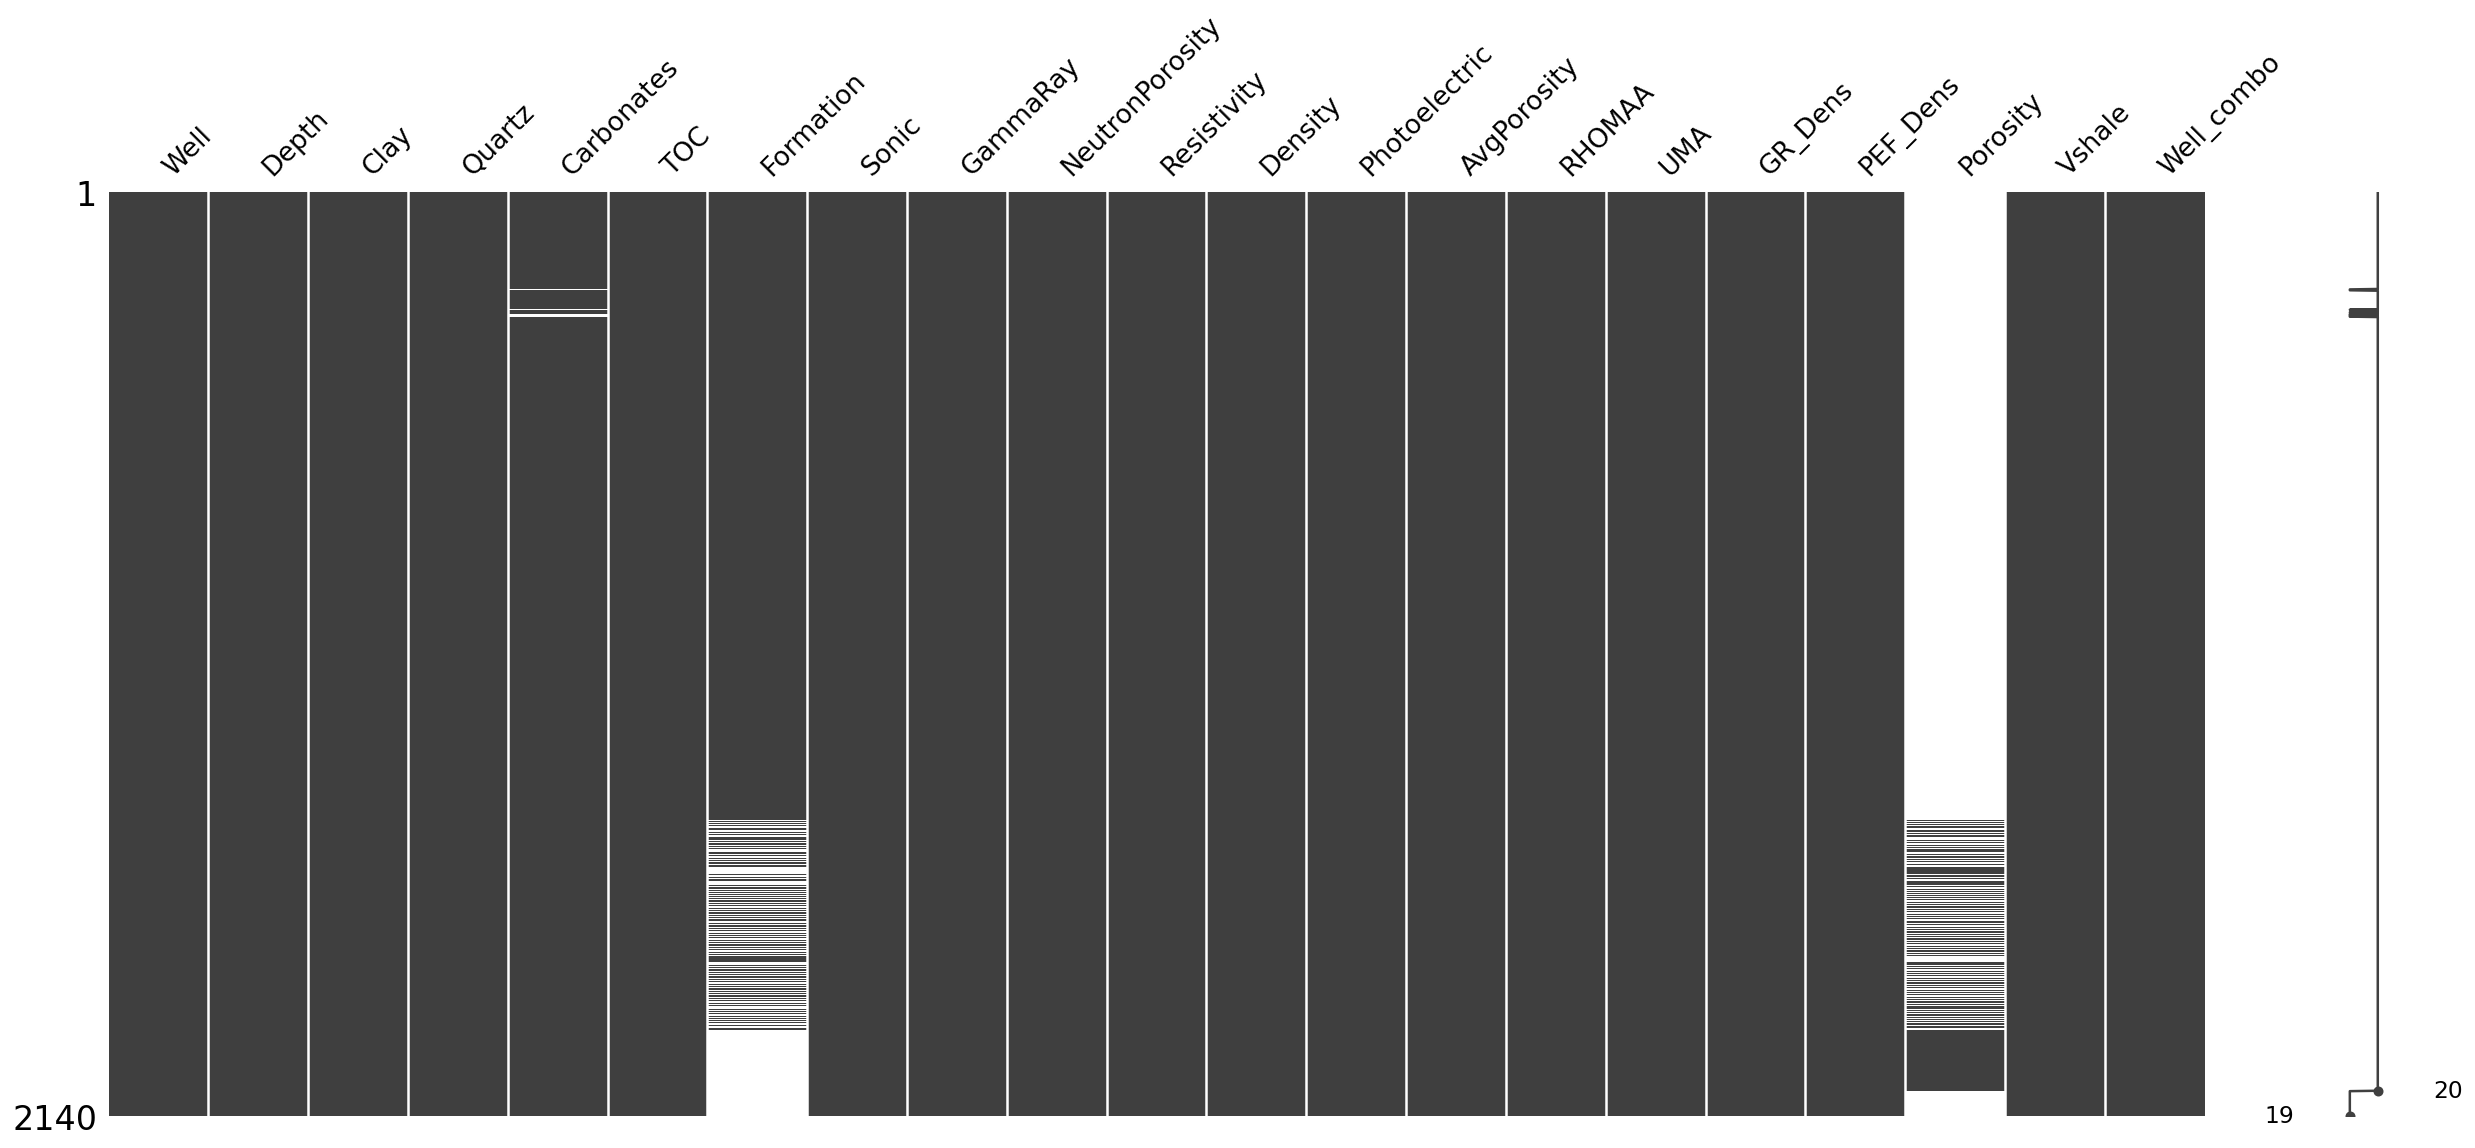

In [172]:
import missingno as msno

msno.matrix(combined_with_vshale)

In [173]:
combined_with_vshale.to_csv('data/combined_with_vshale.csv', index=False)